In [9]:
# !pip install darts

## **Step 1 : Import all the required libraries**

In [15]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Import libraries from darts package
from darts import TimeSeries
from darts import TimeSeries as tm
from darts.models.forecasting.arima import ARIMA
from DataLoading.data_loadiing import DataLoader
from DataVisualization.visualization import DataVisualization
# Import evaluation metrics from darts package
from utils.helper import get_data, Evaluation_matrics, plot_testing_training, \
    plot_visualization as test_plot_visualization ,load_model_sarima_model ,qq_plot,plot_empirical_and_normal
from utils.helper import evaluation_of_model_sarima_Model

from tqdm import tqdm

from utils.arima_helping_utils import plotting_acf_plot ,plotting_pacf_plot
from utils.arima_helping_utils import adfuller_test ,inspect_seasonality
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Step 2 : Read the Data**

In [20]:

# data_file_path = os.path.join('..','Datasets','preprocessed_data',
#              'Weekly_downsampled',
#              'weekly_downsampled_Pennsylvania_Philadelphia.csv')


data_file_path = os.path.join('..','Datasets','raw_data','State_time_series.csv')


filename = data_file_path.split('/')[-1].split('.')[0]
df = pd.read_csv(data_file_path)
df['Date'] = pd.to_datetime(df['Date'])

df.head()




Date  RegionName  DaysOnZillow_AllHomes  \
0 1996-04-30     Alabama                    NaN   
1 1996-04-30     Arizona                    NaN   
2 1996-04-30    Arkansas                    NaN   
3 1996-04-30  California                    NaN   
4 1996-04-30    Colorado                    NaN   

   HomesSoldAsForeclosuresRatio_AllHomes  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   

   InventorySeasonallyAdjusted_AllHomes  InventoryRaw_AllHomes  \
0                                   NaN                    NaN   
1                                   NaN                    NaN   
2                                   NaN                    NaN   
3                                   NaN                    NaN   
4                                   NaN                    NaN   

   MedianListingPricePerSqft_1Bedroom  MedianListingPricePerSqft_2Bedroom  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

   MedianListingPricePerSqft_3Bedroom  MedianListingPricePerSqft_4Bedroom  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

   ...  ZHVI_BottomTier  ZHVI_CondoCoop  ZHVI_MiddleTier  \
0  ...              NaN         99500.0          79500.0   
1  ...          67100.0         78900.0         103600.0   
2  ...          38400.0         70300.0          64400.0   
3  ...          95100.0        136100.0         157900.0   
4  ...          82700.0         99400.0         128100.0   

   ZHVI_SingleFamilyResidence  ZHVI_TopTier  ZRI_AllHomes  \
0                     79000.0      140200.0           NaN   
1                    107500.0      168700.0           NaN   
2                     64500.0      115200.0           NaN   
3                    162000.0      270600.0           NaN   
4                    133600.0      209300.0           NaN   

   ZRI_AllHomesPlusMultifamily  ZriPerSqft_AllHomes  \
0                          NaN                  NaN   
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   

   Zri_MultiFamilyResidenceRental  Zri_SingleFamilyResidenceRental  
0                             NaN                              NaN  
1                             NaN                              NaN  
2                             NaN                              NaN  
3                             NaN                              NaN  
4                             NaN                              NaN  

[5 rows x 86 columns]

<Figure size 3000x2500 with 0 Axes>

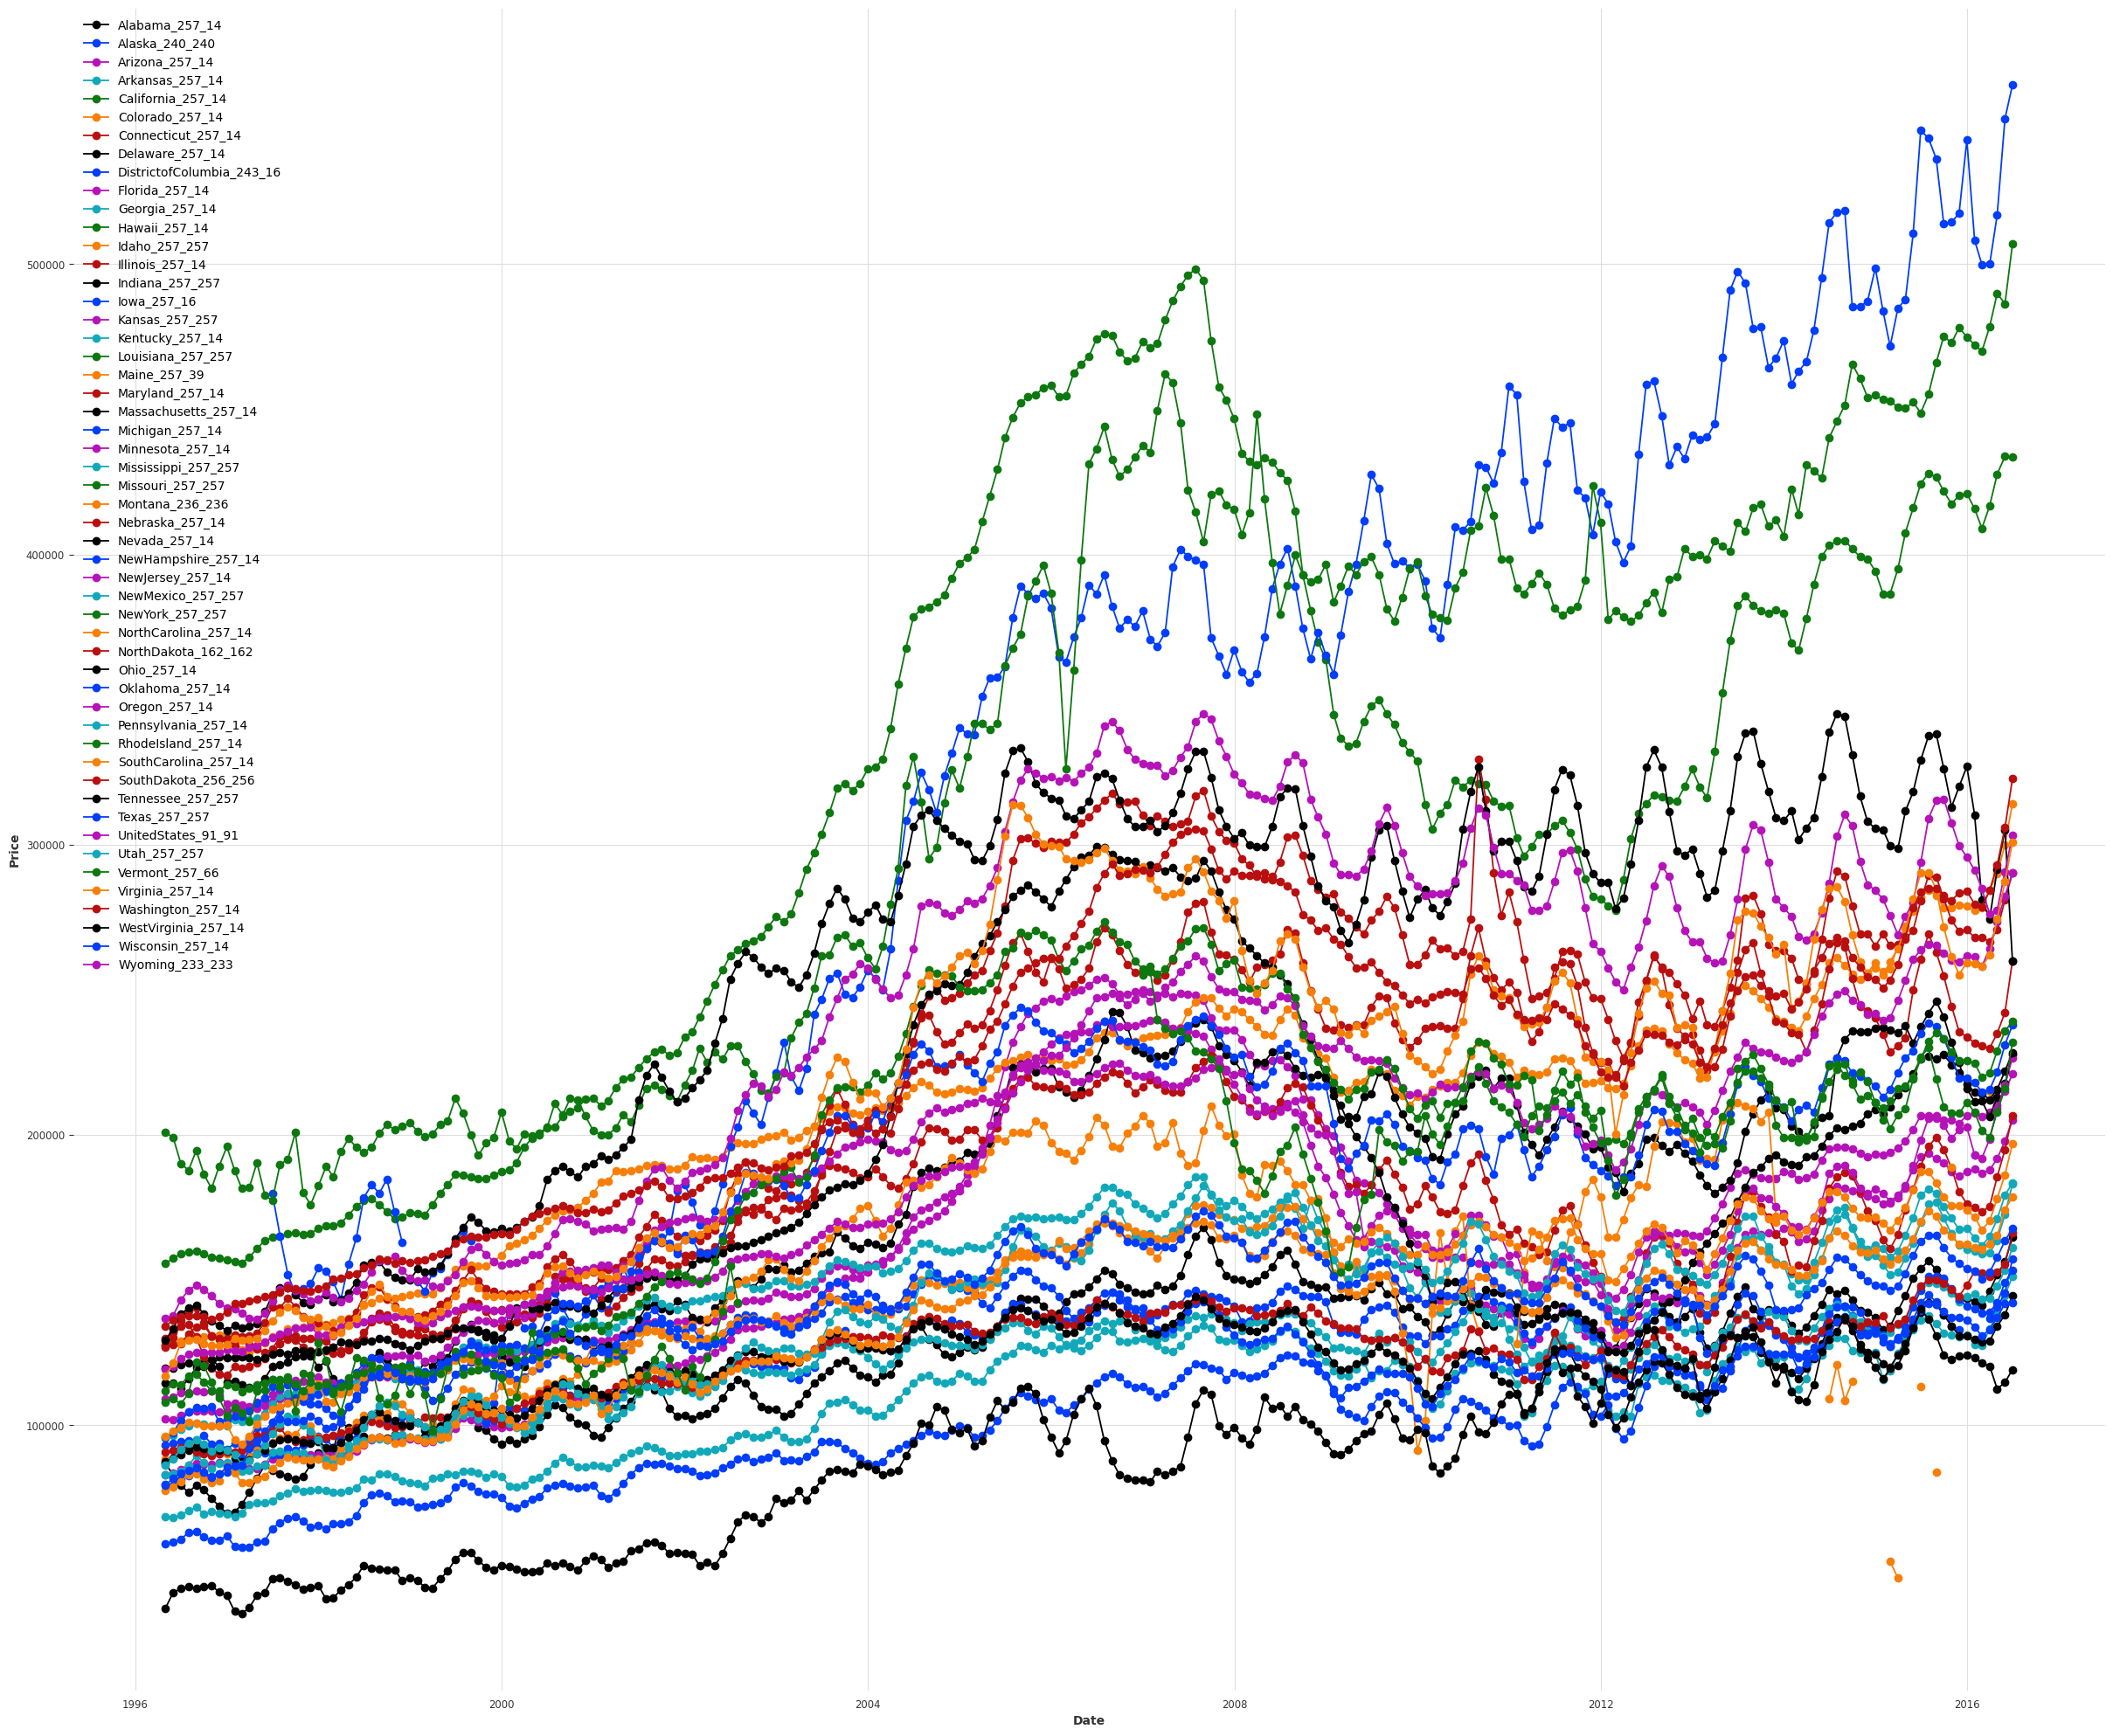

In [21]:
plt.figure(figsize=(30,25))
for name , group_df  in df.groupby(['RegionName']):
    region_df = group_df[['Date','MedianSoldPrice_AllHomes']].sort_values(by='Date')
    filename = os.path.join('..','Datasets','raw_data','regions',f'{name[0]}.csv')
    region_df.to_csv(filename,index=False)
    plt.plot(region_df['Date'],
             group_df['MedianSoldPrice_AllHomes'],
             marker='o',
             label=f"{name[0]}_{region_df.shape[0]}_{region_df['MedianSoldPrice_AllHomes'].isna().sum()}")
    plt.xlabel('Date')
    plt.ylabel('Price')
plt.legend()
plt.savefig('../sample.png')
plt.show()
    # break

In [22]:
filename = os.path.join('..','Datasets','raw_data','regions','Georgia.csv')
df =  pd.read_csv(f'{filename}')
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
# df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

# # Drop rows with missing values
df.dropna(subset=['MedianSoldPrice_AllHomes'], inplace=True)

# # Fill missing values with a specific value, such as 0
# df['MedianSoldPrice_AllHomes'].fillna(0, inplace=True)

df

Date  MedianSoldPrice_AllHomes
0   1996-04-30                   95650.0
1   1996-05-31                   96500.0
2   1996-06-30                   98715.0
3   1996-07-31                   99660.0
4   1996-08-31                  100790.0
..         ...                       ...
238 2016-02-29                  161775.0
239 2016-03-31                  165150.0
240 2016-04-30                  171000.0
241 2016-05-31                  179250.0
242 2016-06-30                  183500.0

[243 rows x 2 columns]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      243 non-null    datetime64[ns]
 1   MedianSoldPrice_AllHomes  243 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.7 KB


## **Step 3 : Converting Data into TimeSeries object**

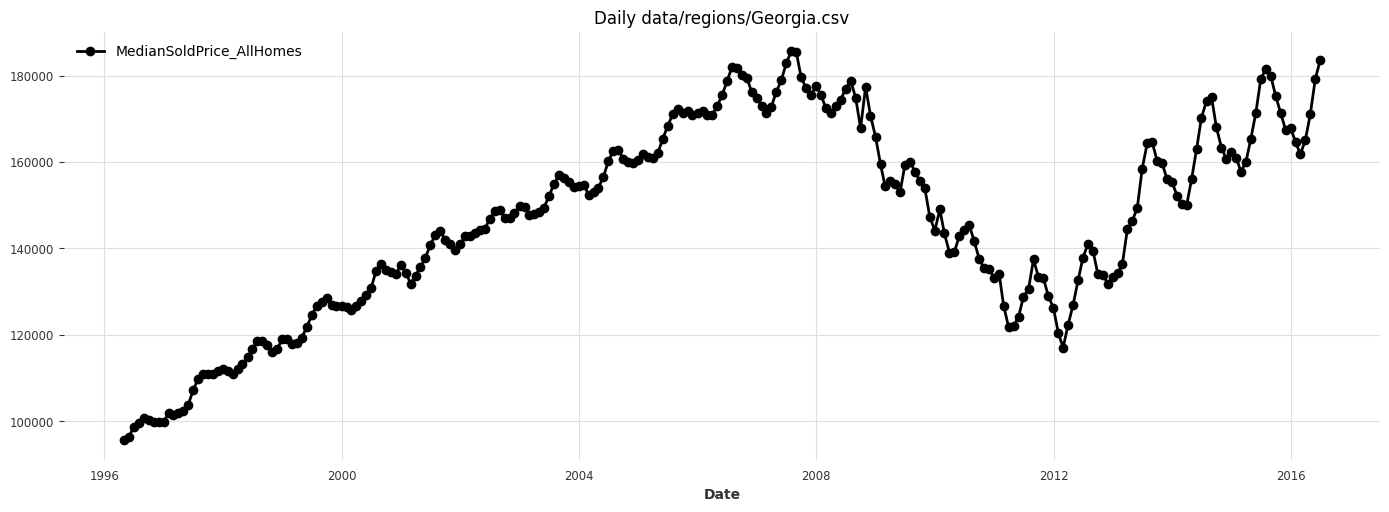

In [25]:
time_series_data = TimeSeries.from_dataframe(df,
                                                time_col='Date',
                                                freq='ME',
                                                fill_missing_dates=True,
                                                fillna_value=True)


plt.figure(figsize=(14,5))
time_series_data.plot(marker='o')
plt.tight_layout()
title = "Daily "+' '.join(filename.split('_')[1:])
plt.title(f"{title}")
plt.show()

## **Step 4 : Splitting Data into Training(In-Sample) & Testing(Out-Sample)**

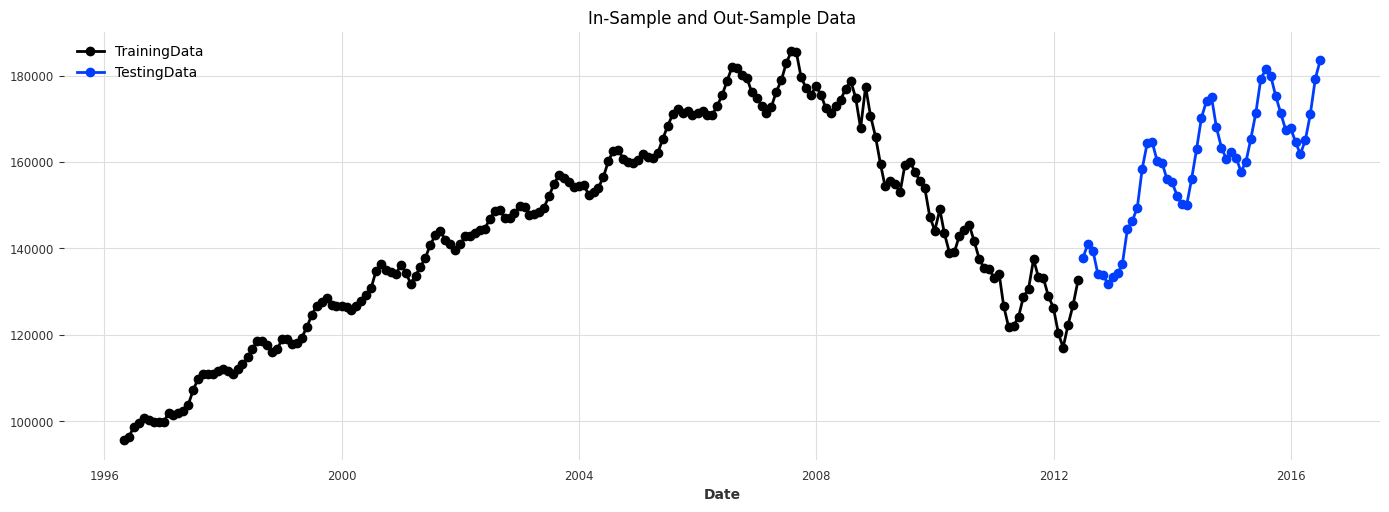

In [26]:
train_series, testing_sc = time_series_data.split_after(0.8)
plt.figure(figsize=(14,5))
train_series.plot(label='TrainingData',marker='o')
testing_sc.plot(label='TestingData',marker='o')
plt.tight_layout()
plt.title('In-Sample and Out-Sample Data')
plt.show()

### **Step 4.1 : Splitting Data into Training(In-Sample) & Testing(Out-Sample) with Differenced**

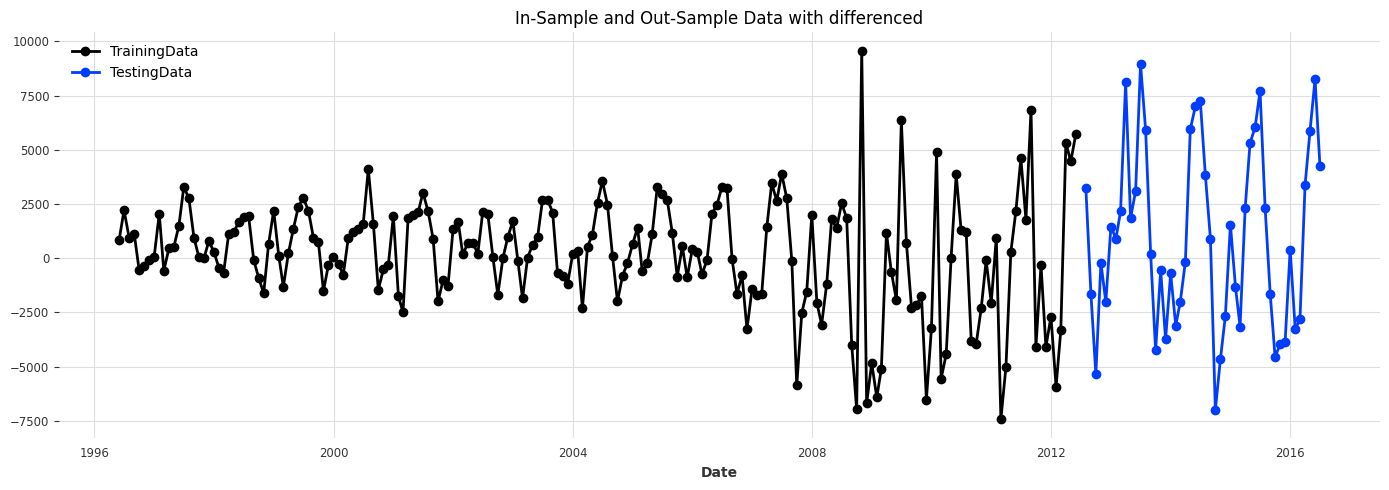

In [42]:
train_series, testing_sc = time_series_data.split_after(0.8)
plt.figure(figsize=(14,5))
train_series.diff(1).plot(label='TrainingData',marker='o')
testing_sc.diff(1).plot(label='TestingData',marker='o')
plt.title('In-Sample and Out-Sample Data with differenced')

plt.tight_layout()
plt.show()

### **Step 4.2 : Plot the Emprical and Fitted Normal Distribution on the in-sample data**

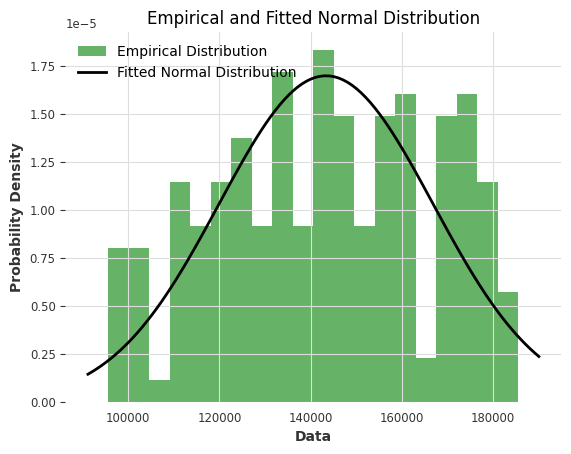

In [28]:
data = train_series.pd_series().values
plot_empirical_and_normal(data)


### **Step 4.3 : Plot the QQ-Plots of In-Sample Data**

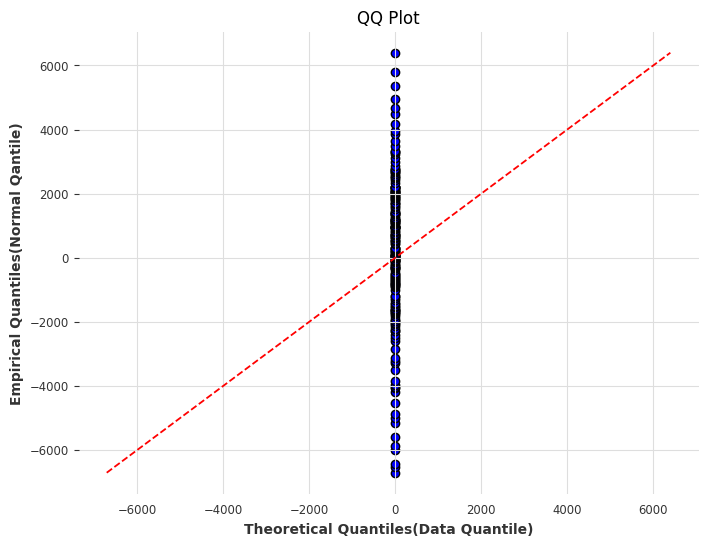

In [29]:
data = train_series.diff(1).pd_series().values
qq_plot(data, distribution='norm')


## **Step 5 : Plotting Auto Correlation part**

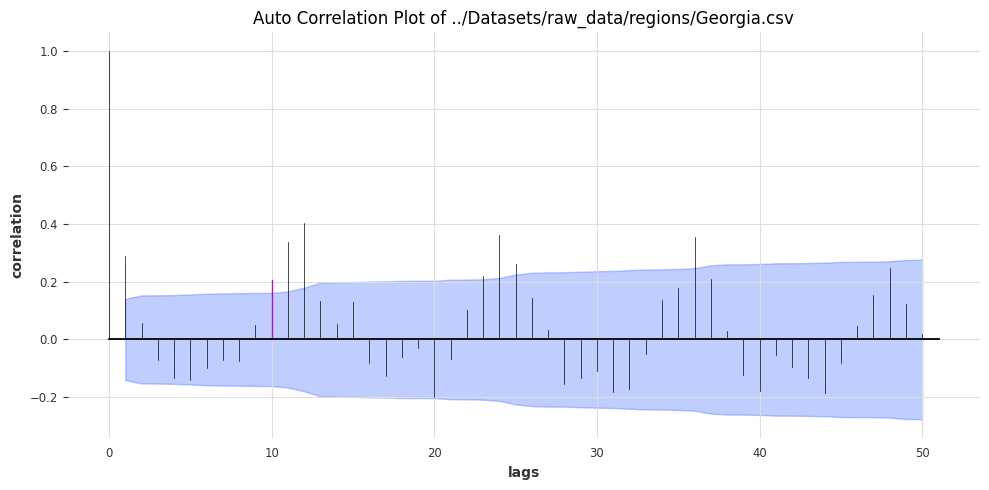

In [51]:
plotting_acf_plot(ts=train_series.diff(1),
                          m=10,
                          max_lag=50,
                          parent_dir_name_for_saving_plots='Plots/SARIMAModel',
                          series_type = ['Training_series','Testing_series'][0],
                          filename = filename
                          )

## **Step 6 : Plotting Partiial Auto Auto Correlation part**

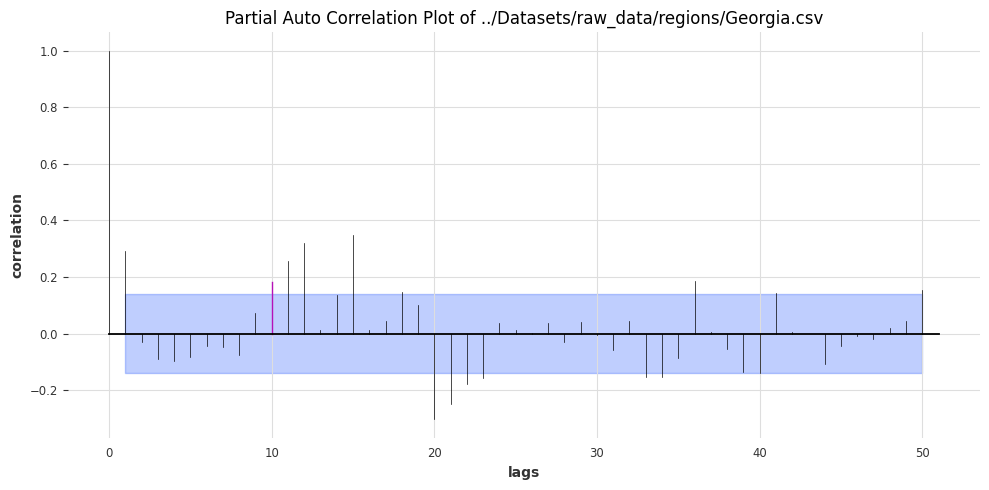

In [52]:
plotting_pacf_plot(ts=train_series.diff(1),
                          m=10,
                          max_lag=50,
                          parent_dir_name_for_saving_plots='Plots/SARIMAModel',
                          series_type = ['Training_series','Testing_series'][0],
                          filename = filename
                          )

## **Step 7 : Checking Stationarity of the Data**

In [37]:
adfuller_test(df['MedianSoldPrice_AllHomes'])

ADF Test Statistic : -2.5842206510162042
p-value : 0.09630259021102355
#Lags Used : 15
Number of Observations Used : 227
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [39]:
df['MedianSoldPrice_AllHomes'].isna().sum()

0

## **Step 8 : Checking Seasonality of the Data**

In [38]:
print('[INFO] Seasonality in the training datasets')
inspect_seasonality(train_series)

[INFO] Seasonality in the training datasets
There is seasonality of order : []


[]

## Applying GridSearch For finding best parameters


In [55]:
minimum_aicc = 0
best_aic = np.inf  # Initialize best AIC value to positive infinity
best_params = None  # Initialize best parameters to None
apply_grid_search_for_finding_best_parameter= True
if apply_grid_search_for_finding_best_parameter == True:

    ts_series = TimeSeries.from_dataframe(df,
                                time_col='Date',
                                value_cols='MedianSoldPrice_AllHomes',
                                freq='ME',
                                fill_missing_dates=True,
                                fillna_value=True)
    
    parent_dir_for_saivng_trained_model_files = os.path.join("..","pkl")
    os.makedirs(parent_dir_for_saivng_trained_model_files,exist_ok=True)



        # Load or initialize the list of trained model filenames
    trained_model_filenames = []
    trained_model_filenames_file = os.path.join(
        parent_dir_for_saivng_trained_model_files, "trained_model_filenames.txt"
    )
    
    if os.path.exists(trained_model_filenames_file):
        with open(trained_model_filenames_file, "r") as file:
            trained_model_filenames = file.read().splitlines()

    train_series, testing_sc = ts_series.split_after(0.8)
    p_values = [2, 3, 9,10]
    d_values = [1,2]
    q_values = [2, 3, 9,10]


    
    # P_values = [0]
    # D_values = [0]
    # Q_values = [0]
    # S_values = [0]
    
    P_values = [2, 3, 4, 9,10]
    D_values = [1,2]
    Q_values = [2, 3, 4, 9,10]
    S_values = [12]
    # Define values for p, d, q, P, D, Q, and S
    
    

    param_combinations = list(
        itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))
    param_combinations_bar = tqdm(param_combinations, desc="Parameter combinations")
    
    # Iterate through all combinations
    for params in param_combinations_bar:
        p, d, q, P, D, Q, S = params
        print(f"Trying parameters: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S}")
        model_file_name = f'{filename}_param_p_{p}_d_{d}_q_{q}_P_{P}_D_{D}_Q_{Q}_S_{S}.pkl'
        # Construct the file path for the trained model
        trained_model_file_name = os.path.join(parent_dir_for_saivng_trained_model_files,model_file_name)
                
        # Skip if the file already exists or is in the list of trained model filenames
        if model_file_name in trained_model_filenames:
            print(f"Model for parameters {params} already trained, skipping...")
            continue

        try:

            arima = ARIMA(p=p, d=d, q=q,
                          seasonal_order=(P, D, Q, S),
                          trend='n',
                          random_state=199,
                          add_encoders=None)
            arima.fit(train_series)
            aic = arima.model.aic
            
            trained_model_filenames.append(model_file_name)  # Add filename to the list
                # Append the filename to the text file
            with open(trained_model_filenames_file, "a") as file:
                file.write(model_file_name + "\n")
        
            # Check if current AIC value is lower than the best AIC value found so far
            if aic < best_aic:
                print(f"AIC for parameters {params}: {aic}")
                print(f'Best Parameters till now : {params}')
                best_aic = aic
                best_params = params
                arima.save(f'{trained_model_file_name}')
                
            
            # Horizon = len(testing_sc)
            # predictions = arima.predict(Horizon)
            # test_plot_visualization(predictions,
            #                         ts_train=train_series,
            #                         ts_test=testing_sc,
            #                         filename=params,
            #                         pollutant_name=selected_pair[0]['aqs_param'])
        except Exception as e:
            print(f'Error has occurred : {e}')
            continue
# Print the best parameters found
print(f"Best parameters based on AIC: {best_params}")


Parameter combinations:   0%|          | 0/1600 [00:00<?, ?it/s]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=2, S=12
Model for parameters (2, 1, 2, 2, 1, 2, 12) already trained, skipping...
Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC for parameters (2, 1, 2, 2, 1, 3, 12): 3365.6464460203138
Best Parameters till now : (2, 1, 2, 2, 1, 3, 12)


Parameter combinations:   0%|          | 2/1600 [00:20<4:36:30, 10.38s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   0%|          | 3/1600 [00:58<9:40:01, 21.79s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   0%|          | 4/1600 [06:59<65:42:32, 148.22s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   0%|          | 5/1600 [14:17<110:25:02, 249.22s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC for parameters (2, 1, 2, 2, 2, 2, 12): 3221.821449047372
Best Parameters till now : (2, 1, 2, 2, 2, 2, 12)


Parameter combinations:   0%|          | 6/1600 [14:38<76:49:07, 173.49s/it] 

Trying parameters: p=2, d=1, q=2, P=2, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   0%|          | 7/1600 [15:11<56:46:13, 128.29s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   0%|          | 8/1600 [16:10<47:05:39, 106.49s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 9/1600 [22:38<85:38:49, 193.80s/it]

Trying parameters: p=2, d=1, q=2, P=2, D=2, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 10/1600 [30:14<121:06:32, 274.21s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 11/1600 [30:40<87:35:10, 198.43s/it] 

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 12/1600 [31:06<64:25:53, 146.07s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 13/1600 [31:47<50:27:11, 114.45s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 14/1600 [38:01<84:57:58, 192.86s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 15/1600 [45:42<120:28:22, 273.63s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 16/1600 [46:20<89:12:52, 202.76s/it] 

Trying parameters: p=2, d=1, q=2, P=3, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 17/1600 [46:59<67:28:53, 153.46s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 18/1600 [48:04<55:45:29, 126.88s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|          | 19/1600 [55:00<93:47:30, 213.57s/it]

Trying parameters: p=2, d=1, q=2, P=3, D=2, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|▏         | 20/1600 [1:04:01<136:53:53, 311.92s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|▏         | 21/1600 [1:04:42<101:07:48, 230.57s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|▏         | 22/1600 [1:05:27<76:43:08, 175.02s/it] 

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   1%|▏         | 23/1600 [1:06:19<60:28:59, 138.07s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 24/1600 [1:12:58<94:41:26, 216.30s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 25/1600 [1:21:30<133:24:13, 304.92s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 26/1600 [1:22:34<101:44:23, 232.70s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 27/1600 [1:23:37<79:26:47, 181.82s/it] 

Trying parameters: p=2, d=1, q=2, P=4, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 28/1600 [1:24:49<65:00:16, 148.87s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 29/1600 [1:31:53<100:58:08, 231.37s/it]

Trying parameters: p=2, d=1, q=2, P=4, D=2, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 30/1600 [1:41:27<145:43:21, 334.14s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=1, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 31/1600 [1:47:15<147:31:57, 338.51s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 32/1600 [1:53:34<152:42:42, 350.61s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 33/1600 [2:00:26<160:34:19, 368.90s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 34/1600 [2:09:03<179:45:15, 413.23s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 35/1600 [2:19:58<211:10:49, 485.78s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 36/1600 [2:26:22<197:51:47, 455.44s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 37/1600 [2:34:37<202:54:40, 467.36s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 38/1600 [2:40:33<188:16:18, 433.92s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▏         | 39/1600 [2:44:22<161:26:54, 372.33s/it]

Trying parameters: p=2, d=1, q=2, P=9, D=2, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   2%|▎         | 40/1600 [2:48:56<148:34:51, 342.88s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=1, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 41/1600 [2:52:16<129:58:21, 300.13s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 42/1600 [2:55:35<116:43:08, 269.70s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 43/1600 [2:59:11<109:37:39, 253.47s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 44/1600 [3:03:23<109:22:27, 253.05s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 45/1600 [3:07:31<108:39:00, 251.54s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 46/1600 [3:11:08<104:10:30, 241.33s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 47/1600 [3:14:54<102:02:39, 236.55s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 48/1600 [3:19:13<104:50:59, 243.21s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 49/1600 [3:24:38<115:25:43, 267.92s/it]

Trying parameters: p=2, d=1, q=2, P=10, D=2, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 50/1600 [3:29:26<117:52:17, 273.77s/it]

Trying parameters: p=2, d=1, q=3, P=2, D=1, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 51/1600 [3:29:38<84:05:44, 195.45s/it] 

Trying parameters: p=2, d=1, q=3, P=2, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 52/1600 [3:30:02<61:52:48, 143.91s/it]

Trying parameters: p=2, d=1, q=3, P=2, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 53/1600 [3:30:32<47:13:28, 109.90s/it]

Trying parameters: p=2, d=1, q=3, P=2, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 54/1600 [3:32:53<51:06:20, 119.00s/it]

Trying parameters: p=2, d=1, q=3, P=2, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   3%|▎         | 55/1600 [3:35:40<57:18:49, 133.55s/it]

Trying parameters: p=2, d=1, q=3, P=2, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▎         | 56/1600 [3:36:03<43:02:00, 100.34s/it]

AIC for parameters (2, 1, 3, 2, 2, 2, 12): 3218.8404167898834
Best Parameters till now : (2, 1, 3, 2, 2, 2, 12)
Trying parameters: p=2, d=1, q=3, P=2, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▎         | 57/1600 [3:36:31<33:44:38, 78.73s/it] 

Trying parameters: p=2, d=1, q=3, P=2, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▎         | 58/1600 [3:37:12<28:48:35, 67.26s/it]

Trying parameters: p=2, d=1, q=3, P=2, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▎         | 59/1600 [3:39:56<41:15:44, 96.39s/it]

Trying parameters: p=2, d=1, q=3, P=2, D=2, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 60/1600 [3:44:01<60:17:53, 140.96s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=1, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 61/1600 [3:44:24<45:10:49, 105.68s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 62/1600 [3:44:51<34:58:52, 81.88s/it] 

Trying parameters: p=2, d=1, q=3, P=3, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 63/1600 [3:45:26<28:56:03, 67.77s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 64/1600 [3:47:52<38:56:33, 91.27s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 65/1600 [3:50:53<50:28:03, 118.36s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 66/1600 [3:51:35<40:39:04, 95.40s/it] 

Trying parameters: p=2, d=1, q=3, P=3, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 67/1600 [3:52:05<32:16:11, 75.78s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 68/1600 [3:52:50<28:21:33, 66.64s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 69/1600 [3:55:54<43:11:37, 101.57s/it]

Trying parameters: p=2, d=1, q=3, P=3, D=2, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 70/1600 [3:59:34<58:20:33, 137.28s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=1, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 71/1600 [4:00:12<45:37:33, 107.43s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=1, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   4%|▍         | 72/1600 [4:00:53<37:11:48, 87.64s/it] 

Trying parameters: p=2, d=1, q=3, P=4, D=1, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   5%|▍         | 73/1600 [4:01:35<31:15:21, 73.69s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=1, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   5%|▍         | 74/1600 [4:04:13<42:00:08, 99.09s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=1, Q=10, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   5%|▍         | 75/1600 [4:07:30<54:25:46, 128.49s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=2, Q=2, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   5%|▍         | 76/1600 [4:08:10<43:09:23, 101.94s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=2, Q=3, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   5%|▍         | 77/1600 [4:08:58<36:13:57, 85.65s/it] 

Trying parameters: p=2, d=1, q=3, P=4, D=2, Q=4, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   5%|▍         | 78/1600 [4:09:46<31:30:01, 74.51s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=2, Q=9, S=12


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Parameter combinations:   5%|▍         | 79/1600 [4:25:05<138:26:51, 327.69s/it]

Trying parameters: p=2, d=1, q=3, P=4, D=2, Q=10, S=12


Parameter combinations:   5%|▍         | 79/1600 [4:36:14<88:38:25, 209.80s/it] 


KeyboardInterrupt: 

In [56]:
best_aic,best_params

(3218.8404167898834, (2, 1, 3, 2, 2, 2, 12))

## **Step 9 : Fitting the Model & Training the SARIMA Model**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  194
Model:             ARIMA(10, 1, 10)x(2, 2, [1, 2], 12)   Log Likelihood               -1590.044
Date:                                 Thu, 11 Apr 2024   AIC                           3230.087
Time:                                         16:34:33   BIC                           3308.335
Sample:                                              0   HQIC                          3261.842
                                                 - 194                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1102     78.541     -0.001      0.999    -154.048     153

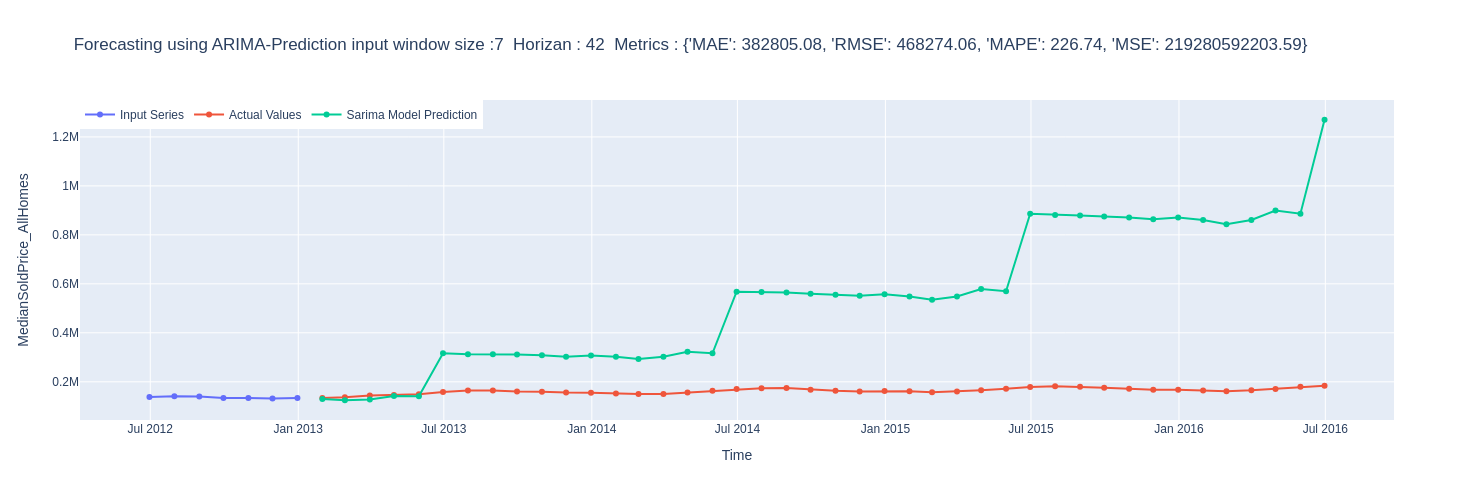

Evaluation of input window : 14 & Horizon : 35
metrics: {'MAE': 140202.36, 'RMSE': 167232.87, 'MAPE': 82.74, 'MSE': 27966833798.37}


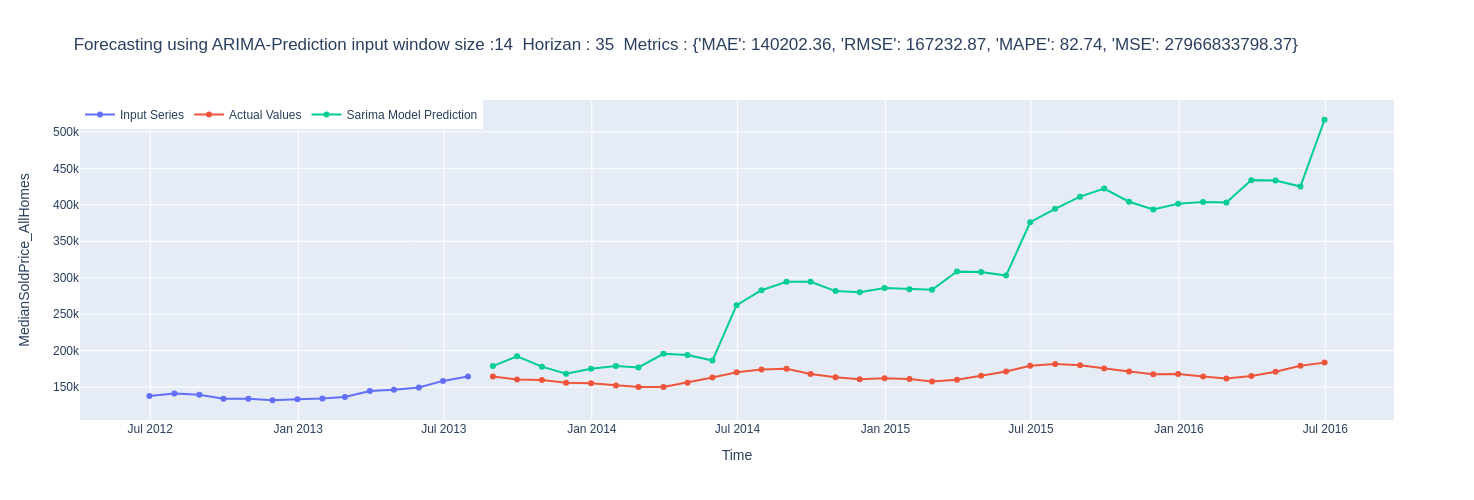

Evaluation of input window : 21 & Horizon : 28
metrics: {'MAE': 111105.71, 'RMSE': 124496.02, 'MAPE': 65.21, 'MSE': 15499260226.76}


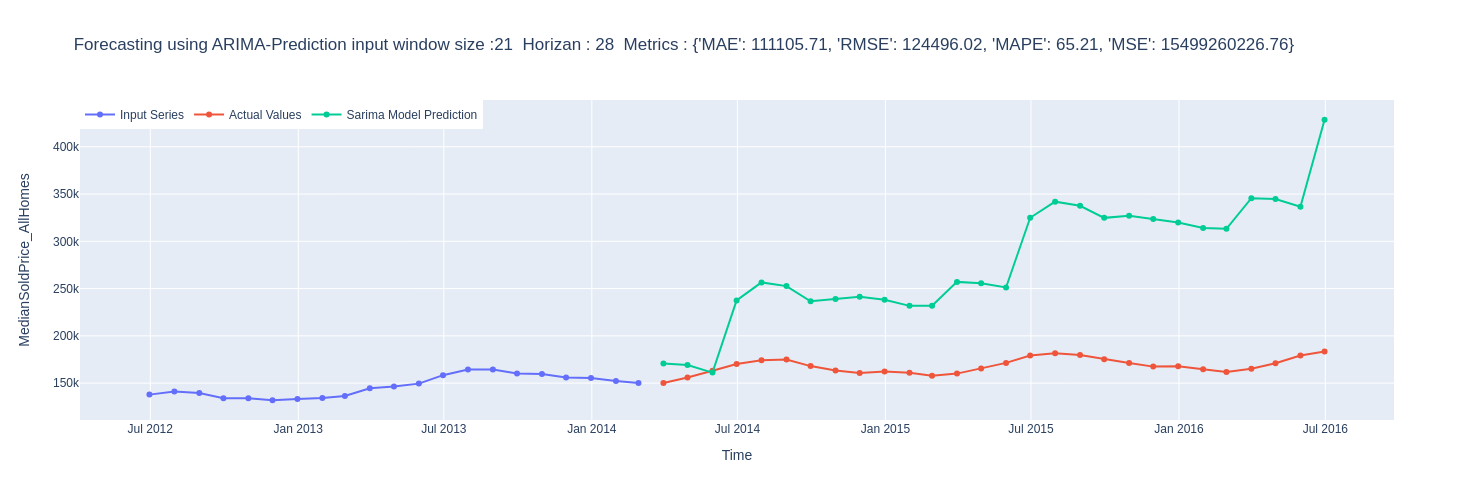

Evaluation of input window : 28 & Horizon : 21
metrics: {'MAE': 8211.58, 'RMSE': 9503.18, 'MAPE': 4.77, 'MSE': 90310514.62}


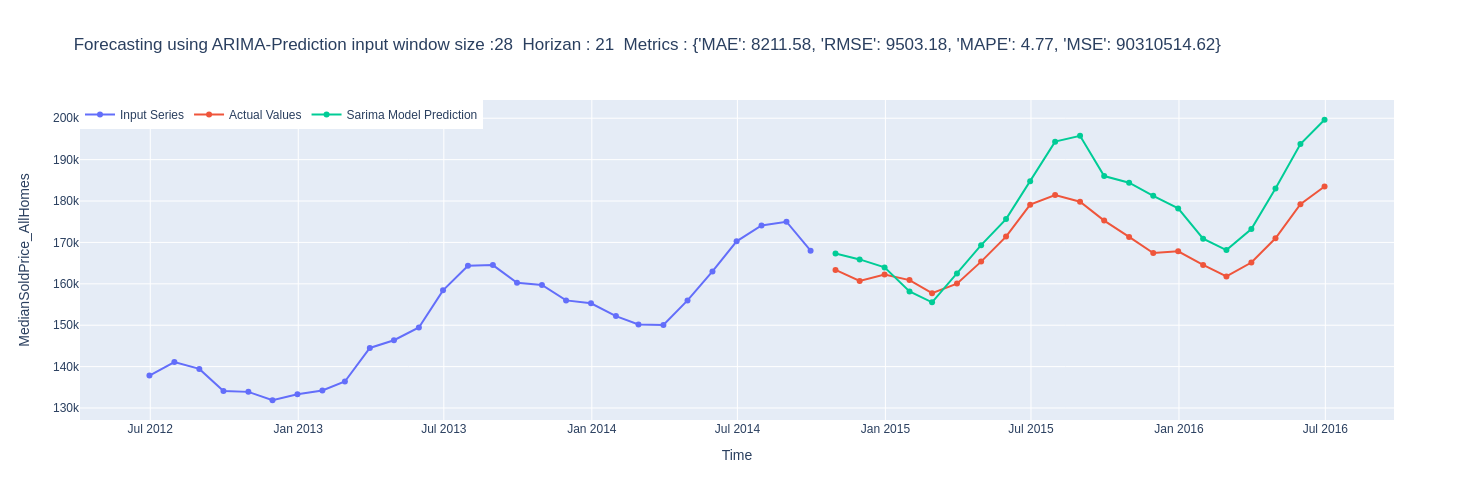

Evaluation of input window : 35 & Horizon : 14
metrics: {'MAE': 6369.68, 'RMSE': 7090.47, 'MAPE': 3.65, 'MSE': 50274767.04}


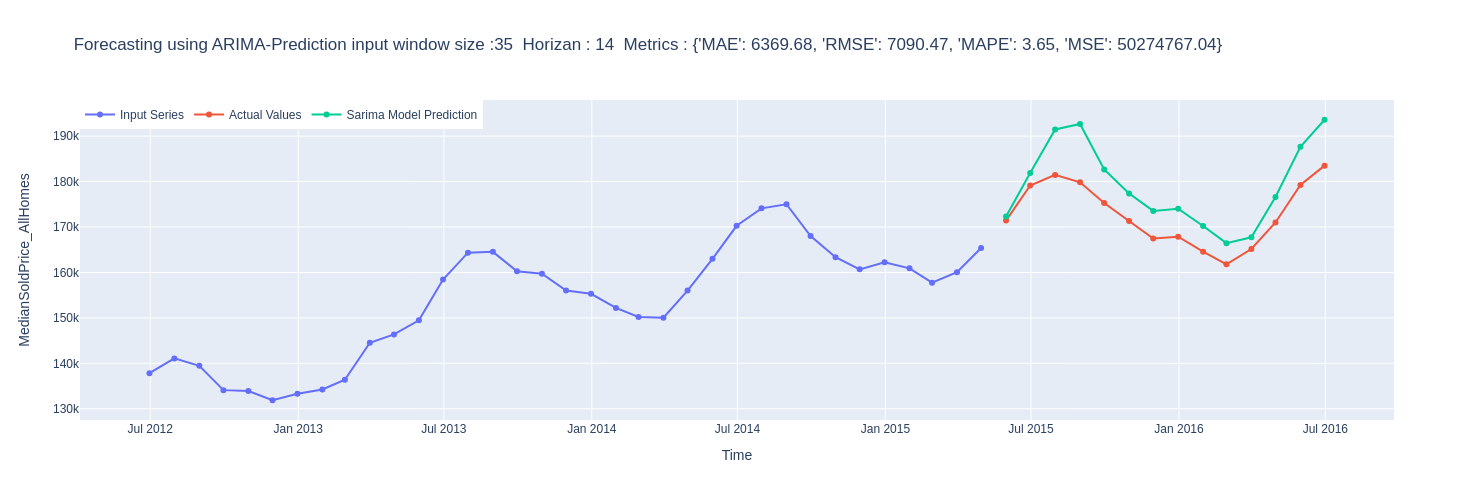

Evaluation of input window : 42 & Horizon : 7
metrics: {'MAE': 1507.35, 'RMSE': 1875.28, 'MAPE': 0.9, 'MSE': 3516685.23}


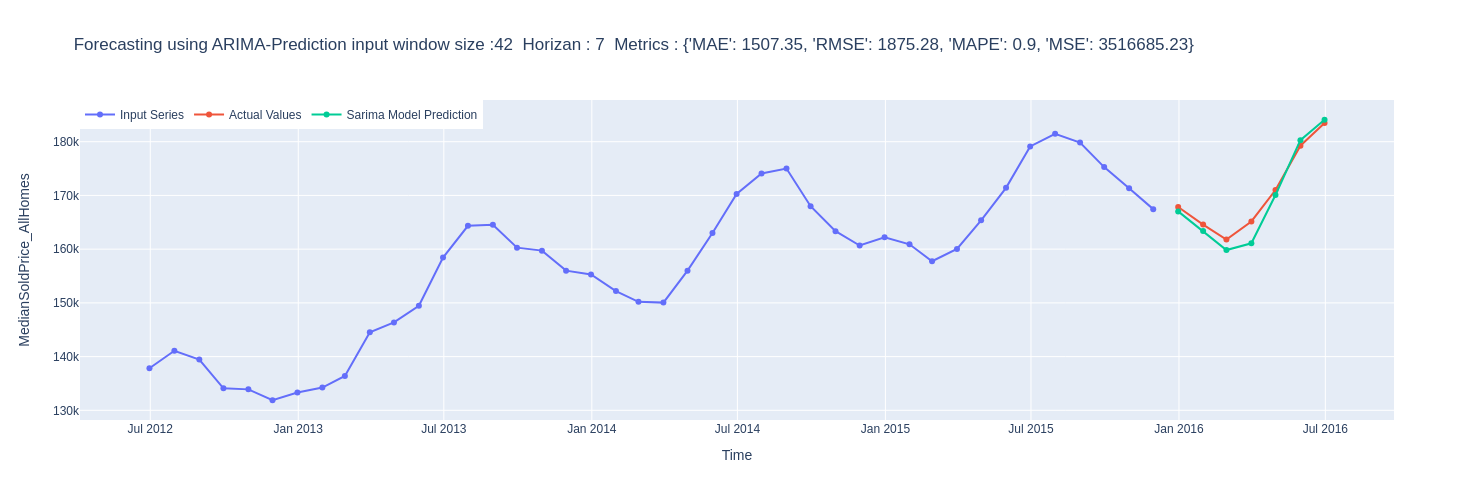

In [61]:

parent_dir_for_saivng_trained_model_files = os.path.join("..","pkl")
os.makedirs(parent_dir_for_saivng_trained_model_files,exist_ok=True)



# Define values for p, d, q, P, D, Q, and S
p, d, q, P, D, Q, S = 10, 1, 10, 2, 2,2,12 
model_file_name = f'{filename}_param_p_{p}_d_{d}_q_{q}_P_{P}_D_{D}_Q_{Q}_S_{S}.pkl'


# Construct the file path for the trained model
trained_model_file_name = os.path.join(parent_dir_for_saivng_trained_model_files,model_file_name)


Horizon = len(testing_sc)

# Check if the model file already exists
if model_file_name not in os.listdir(parent_dir_for_saivng_trained_model_files):
    # Model file does not exist, create a new ARIMA model, save it, and fit it
    try:
        
        arima = ARIMA(p=p, d=d, q=q,
                      seasonal_order=(P, D, Q, S),
                      trend='n',
                      random_state=1999,
                      add_encoders=None)
    
        arima.fit(train_series)
        arima.save(trained_model_file_name)
    except Exception as e:
        print(f'Error occurred at : {e}')
    
else:
    print("Model file exists, load the existing ARIMA model")
    arima = load_model_sarima_model(model_name=trained_model_file_name)



# Print ARIMA model summary
if arima is not None:
    print(arima.model.summary())
else:
    print("ARIMA model is None, could not print summary.")



evaluation_sarima_df = evaluation_of_model_sarima_Model(trained_model_file_name,
                                                ts_test=testing_sc,
                                                ts_train=train_series)

## **Step 10 : Taking Prediction from the Trained Model**

In [62]:

predictions = arima.predict(Horizon)


## **Step 11 : Verifying the prediction using visualization**

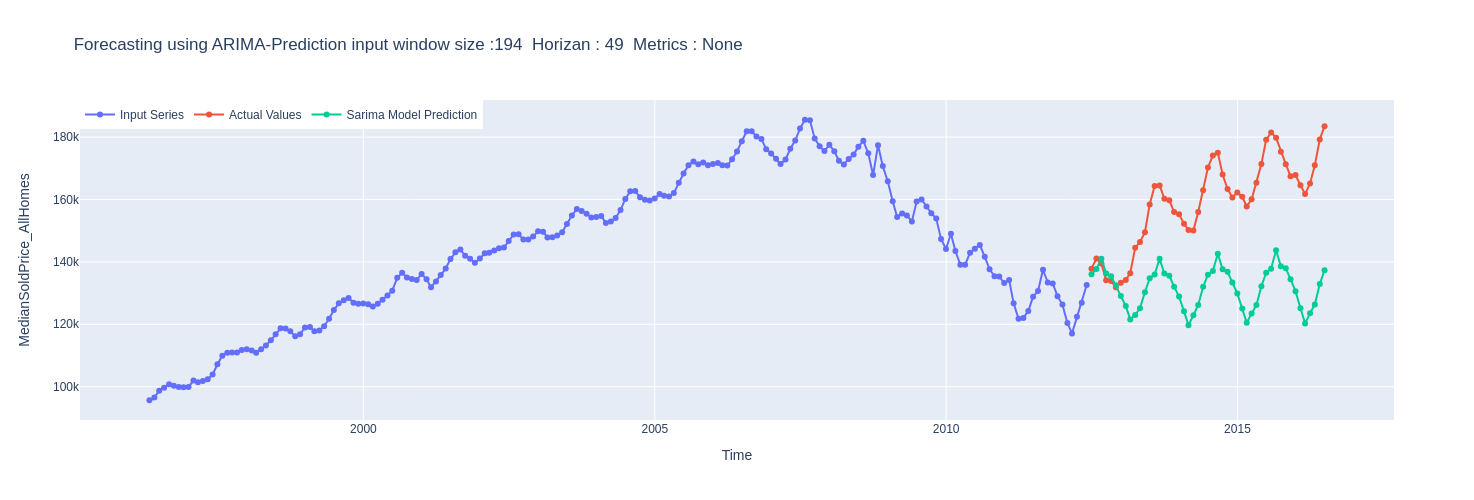

In [63]:
test_plot_visualization(predictions,
                        ts_train=train_series,
                        ts_test=testing_sc,
                        filename=filename.split('/')[-1].split('.')[0])

## **Step 12 : Evaluation of the Model**

Evaluation of input window : 7 & Horizon : 42
metrics: {'MAE': 382805.08, 'RMSE': 468274.06, 'MAPE': 226.74, 'MSE': 219280592203.59}


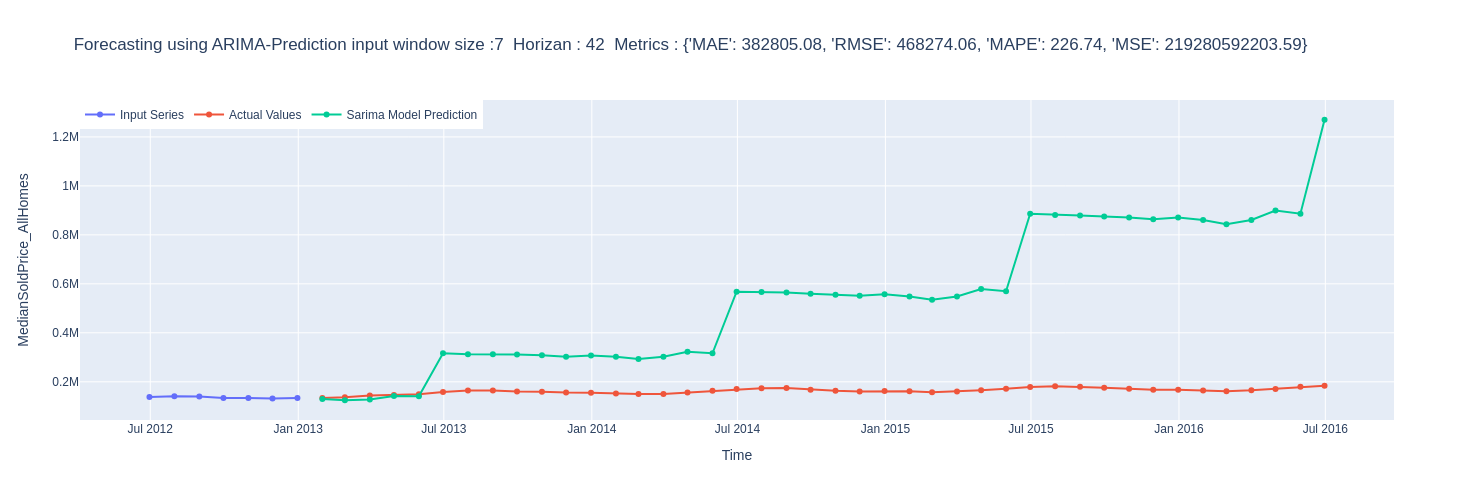

Evaluation of input window : 14 & Horizon : 35
metrics: {'MAE': 140202.36, 'RMSE': 167232.87, 'MAPE': 82.74, 'MSE': 27966833798.37}


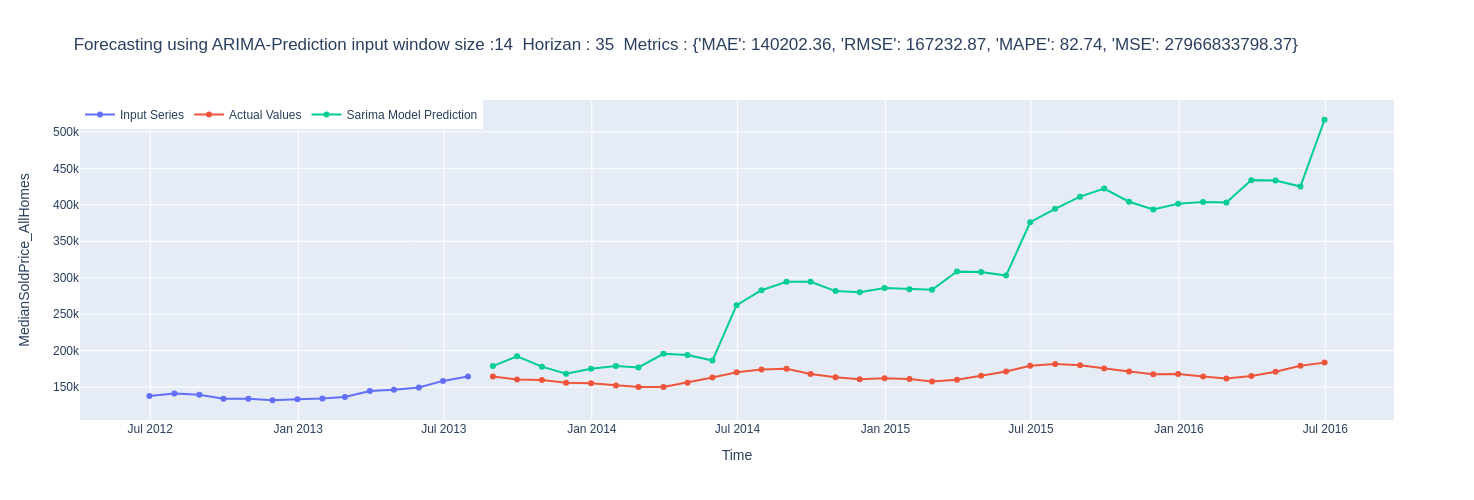

Evaluation of input window : 21 & Horizon : 28
metrics: {'MAE': 111105.71, 'RMSE': 124496.02, 'MAPE': 65.21, 'MSE': 15499260226.76}


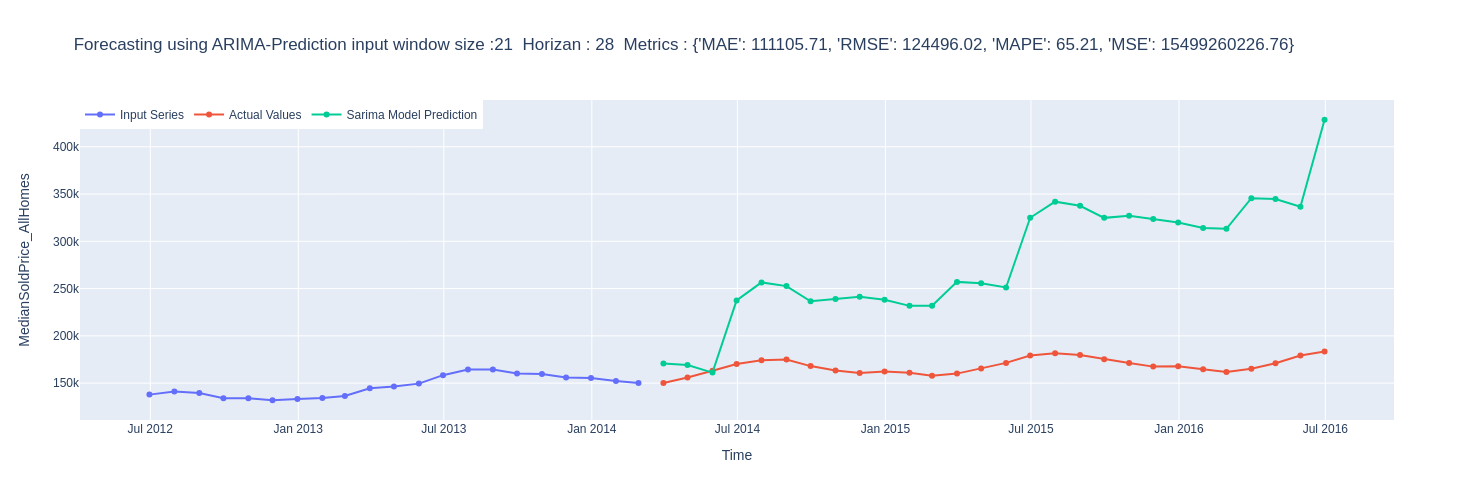

Evaluation of input window : 28 & Horizon : 21
metrics: {'MAE': 8211.58, 'RMSE': 9503.18, 'MAPE': 4.77, 'MSE': 90310514.62}


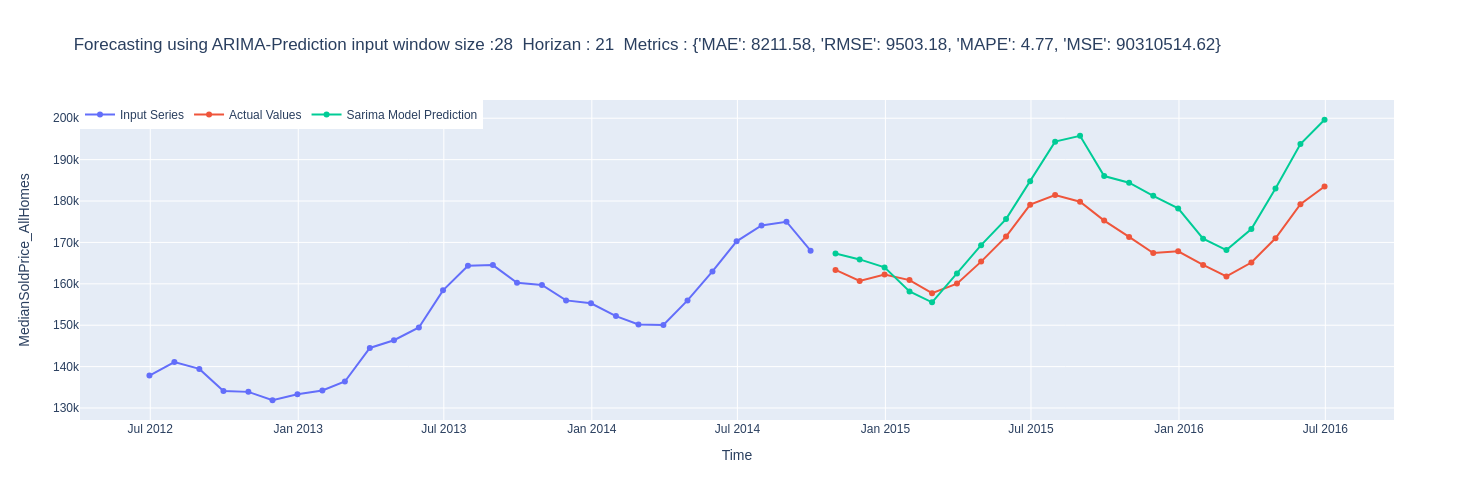

Evaluation of input window : 35 & Horizon : 14
metrics: {'MAE': 6369.68, 'RMSE': 7090.47, 'MAPE': 3.65, 'MSE': 50274767.04}


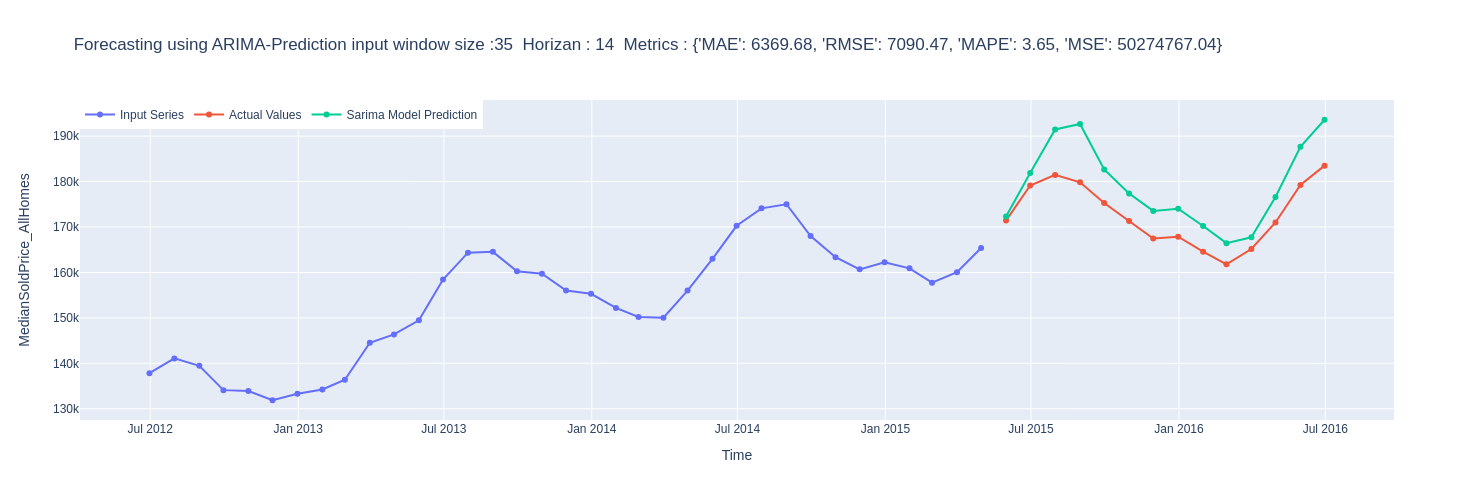

Evaluation of input window : 42 & Horizon : 7
metrics: {'MAE': 1507.35, 'RMSE': 1875.28, 'MAPE': 0.9, 'MSE': 3516685.23}


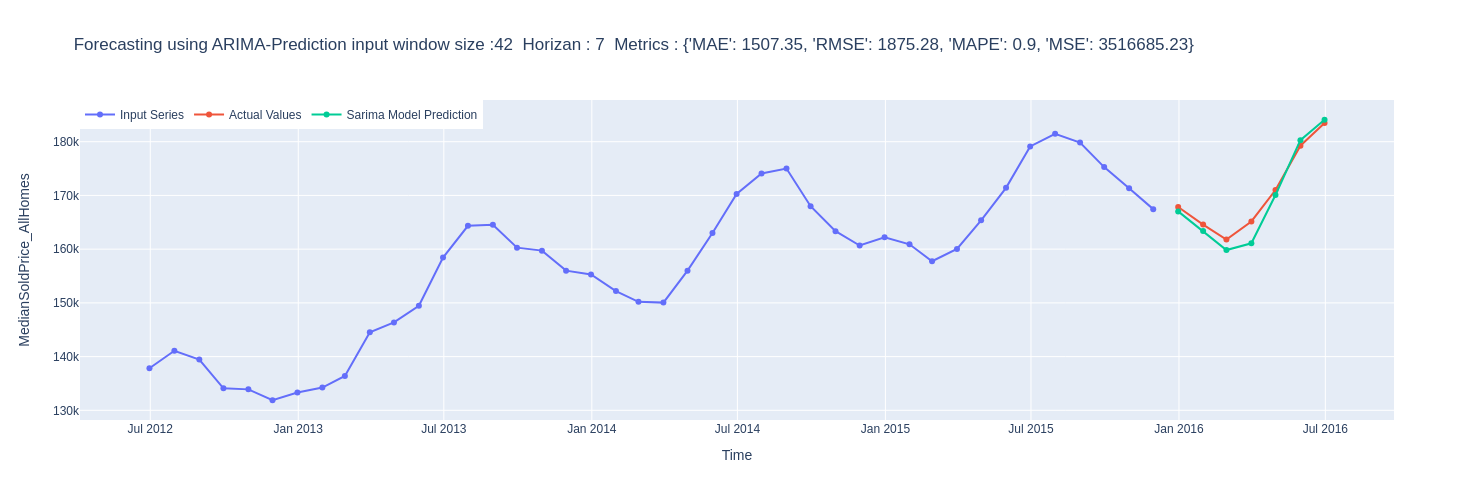

In [64]:

evaluation_sarima_df = evaluation_of_model_sarima_Model(trained_model_file_name,
                                                ts_test=testing_sc,
                                                ts_train=train_series)

In [65]:
result_dir_path = '../ModelResults'
os.makedirs(result_dir_path,exist_ok=True)
evaluation_sarima_df.to_csv(f"{result_dir_path}/results_{trained_model_file_name.split('/')[-1].split('.')[0]}.csv",index=False)

results

In [66]:
evaluation_sarima_df

input_window_in_days  output_window_in_days        MAE       RMSE    MAPE  \
0                     7                     42  382805.08  468274.06  226.74   
1                    14                     35  140202.36  167232.87   82.74   
2                    21                     28  111105.71  124496.02   65.21   
3                    28                     21    8211.58    9503.18    4.77   
4                    35                     14    6369.68    7090.47    3.65   
5                    42                      7    1507.35    1875.28    0.90   

            MSE  
0  2.192806e+11  
1  2.796683e+10  
2  1.549926e+10  
3  9.031051e+07  
4  5.027477e+07  
5  3.516685e+06

In [76]:
evaluation_sarima_df['MSE'][2]

15499260226.76

In [178]:
evaluation_sarima_df